# Self-Driving Car Engineer Nanodegree


## Project: **Advanced lane finding** 

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Libraries import & Constants definition

In [1]:
# Jupyter configuration: C:\Users\<USER>\.jupyter\jupyter_notebook_config.py
# c.NotebookApp.browser = u'C:/Program Files/Mozilla Firefox/firefox.exe %s'
# c.NotebookApp.notebook_dir = 'D:/workspaces'

# Remove autoclosing and add lane numbers
#from notebook.services.config import ConfigManager
#c = ConfigManager()
#c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False, "lineNumbers": True}}})

In [149]:
import os
import glob # library for loading images from a directory
import random
#import pickle
import cv2
import numpy as np

import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

# Video edition
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [147]:
IMAGE_CALIB_DIR = "camera_cal"
IMAGE_TEST_DIR = "test_images"
CHESS_WIDTH = 9
CHESS_HEIGHT = 6
VIDEO_PATH_CHALLENGE = 'challenge_video.mp4'
VIDEO_PATH_HARDER_CHALLENGE = 'harder_challenge_video.mp4'

## Camera calibration
Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [4]:
def calibrate(img_dir, chess_width, chess_height):
    # Inspired from: https://medium.com/@aliyasineser/opencv-camera-calibration-e9a48bdd1844
    # - Decided not to load the image list in a separate function not to fill RAM
    
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane
    image_shape = None
        
    # Iterate through each image file in the directory
    # glob reads in any image with the extension "image_dir/im_type/*"
    for file in glob.glob(os.path.join(img_dir, "*")):

        # Read in the image
        img = cv2.imread(file)
        
        # Retrieve image shape once
        if image_shape is None:
            # Assuming all images have same shape
            img_shape = img.shape[1::-1]

        # Check if the image exists / if it's been correctly read
        if not img is None:
            # Get image object points and image points
            objp, imgp = get_image_objp_imgp(img, chess_width, chess_height)
            
            # Check if corners were found
            if not objp is None:
                # Append the image points matrix
                imgpoints.append(imgp)
                # Append the corresponding objects points matrix
                objpoints.append(objp)
            else:
                print("WARNING: Could not extract chessboard from image '{}'".format(file))
    
    # All calibration images were processed, compute calibration matrix and distortion    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)    

    return ret, mtx, dist, rvecs, tvecs

def get_image_objp_imgp(img, chess_width, chess_height):
    # Convert image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find image points
    ret, corners = cv2.findChessboardCorners(gray, (chess_width, chess_height), None)

    # Check if corners were found
    if ret:
        # Image points (corners)        
        # TODO: Could refine location with cornerSubPix
        imgpoints = corners
        
        # Chessboard (x,y) list of points, which will correspond to found (pixel_x, pixel_y) image points
        objpoints = np.zeros((chess_width*chess_height, 3), np.float32)
        objpoints[:, :2] = np.mgrid[0:chess_width, 0:chess_height].T.reshape(-1, 2)
        
        return objpoints, imgpoints
    
    return None, None

In [5]:
# Retrieve calibration matrix and distortion coefficients 
ret, mtx, dist, rvecs, tvecs = calibrate(IMAGE_CALIB_DIR, CHESS_WIDTH, CHESS_HEIGHT)
#print([ret, mtx, dist, rvecs, tvecs])

### Execution result
Observing calibration image 1, 4 and 5 cannot be processed. Is this normal?
Should the code be adapted on a per image basis: Check the object points displayed and append them accordingly with image points

## Distortion correction 
Apply a distortion correction to raw images.

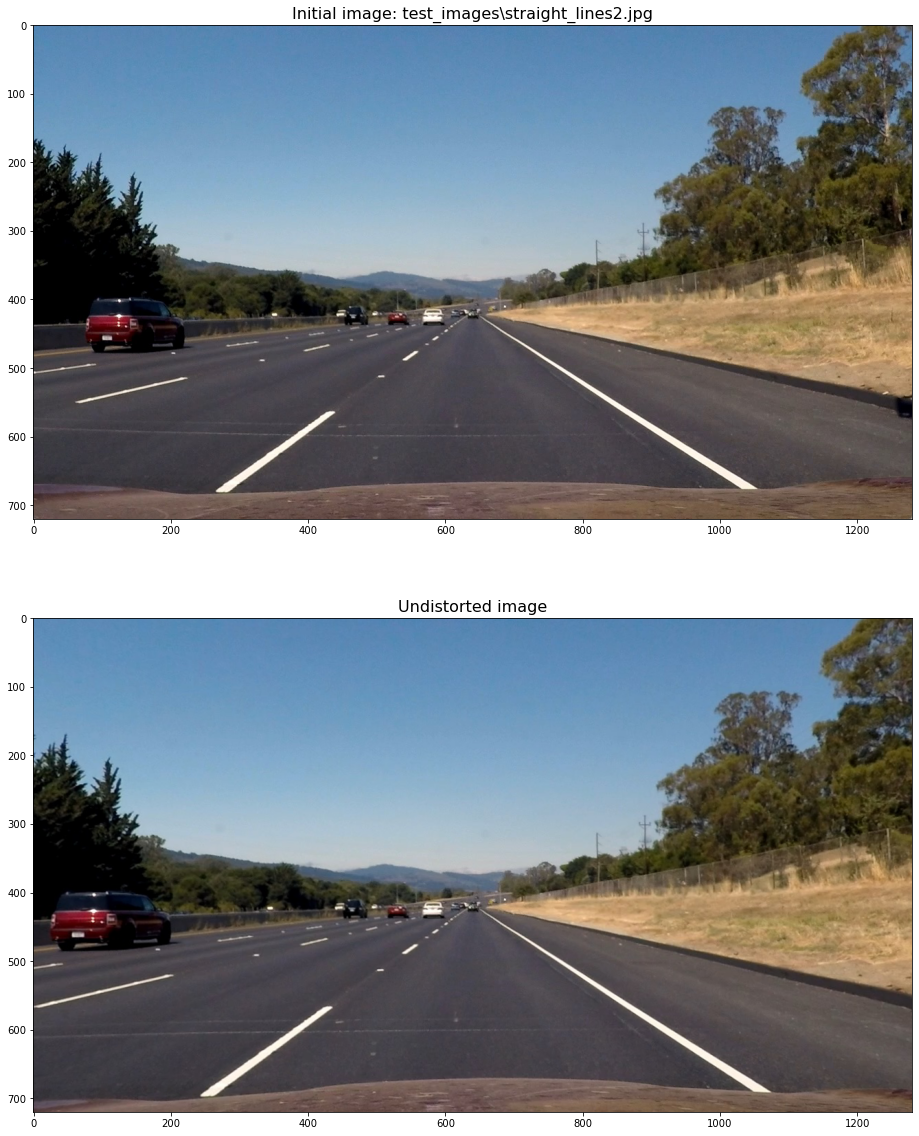

In [6]:
def pick_rand_dir_img(img_dir):
    
    # List all files in directory
    dir_files = [os.path.join(IMAGE_TEST_DIR, f) for f in os.listdir(IMAGE_TEST_DIR) if os.path.isfile(os.path.join(IMAGE_TEST_DIR, f))]
    
    # Pick a random file
    img_file_path = random.choice(dir_files)

    return img_file_path

img_file_path = pick_rand_dir_img(IMAGE_TEST_DIR)
# Read in the image
img = cv2.imread(img_file_path)

img_undistort = cv2.undistort(img, mtx, dist, None, mtx)

# Display with CV2
#cv2.imshow('Image', img)
# Add those 2 lines to prevent cv2 from crashing
#cv2.waitKey(0) 
#cv2.destroyWindow('Image')

# Display with matplotlib
f, ((ax11), (ax12)) = plt.subplots(2, 1, figsize=(20,20))    
ax11.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax11.set_title("Initial image: {}".format(img_file_path), fontsize=16)
ax12.imshow(cv2.cvtColor(img_undistort, cv2.COLOR_BGR2RGB))
ax12.set_title("Undistorted image", fontsize=16)
plt.show()

## Filtered image
Use color transforms, gradients, etc., to create a thresholded binary image.

In [7]:
def gaussian_blur(img_hls_l, ksize=3):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img_hls_l, (ksize, ksize), 0)

def abs_sobel_thresh(img_hls_l, orient='x', ksize=3, abs_thresh=(0, 255)):
    # Calculate directional gradient
    if orient == 'x':
        sobel = cv2.Sobel(img_hls_l, cv2.CV_64F, 1, 0, ksize=ksize)
    else:
        sobel = cv2.Sobel(img_hls_l, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
    return grad_binary

def mag_threshold(img_hls_l, ksize=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    sobel_x = cv2.Sobel(img_hls_l, cv2.CV_64F, 1, 0, ksize=ksize)
    sobel_y = cv2.Sobel(img_hls_l, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    abs_sobel = np.sqrt((abs_sobel_x**2 + abs_sobel_y**2))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Apply threshold
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img_hls_l, ksize=3, dir_thresh=(0, np.pi/2)):
    # Calculate gradient direction
    sobel_x = cv2.Sobel(img_hls_l, cv2.CV_64F, 1, 0, ksize=ksize)
    sobel_y = cv2.Sobel(img_hls_l, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    arctan_sobel = np.arctan2(abs_sobel_y, abs_sobel_x)

    # Apply threshold
    dir_binary = np.zeros_like(arctan_sobel)
    dir_binary[(arctan_sobel >= dir_thresh[0]) & (arctan_sobel <= dir_thresh[1])] = 1
    return dir_binary

def col_threshold(img_hls_s, ksize=3, col_thresh=(170, 255)):
    # Threshold color channel
    col_binary = np.zeros_like(img_hls_s)
    col_binary[(img_hls_s >= col_thresh[0]) & (img_hls_s <= col_thresh[1])] = 1
    return col_binary

def filter_pipeline(img, ksize=3, abs_thresh=(0, 255), mag_thresh=(0, 255), dir_thresh=(0, 255), col_thresh=(170, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the L/S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    l_channel = gaussian_blur(l_channel, ksize)
    
    gradx_binary = abs_sobel_thresh(l_channel, orient='x', ksize=ksize, abs_thresh=abs_thresh)
    grady_binary = abs_sobel_thresh(l_channel, orient='y', ksize=ksize, abs_thresh=abs_thresh)
    mag_binary = mag_threshold(l_channel, ksize=ksize, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(l_channel, ksize=ksize, dir_thresh=dir_thresh)
    
    col_binary = col_threshold(s_channel, ksize, col_thresh=(170, 255))
    
    combined = np.zeros_like(l_channel)
    combined[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary == 1)] = 1
    
    return combined

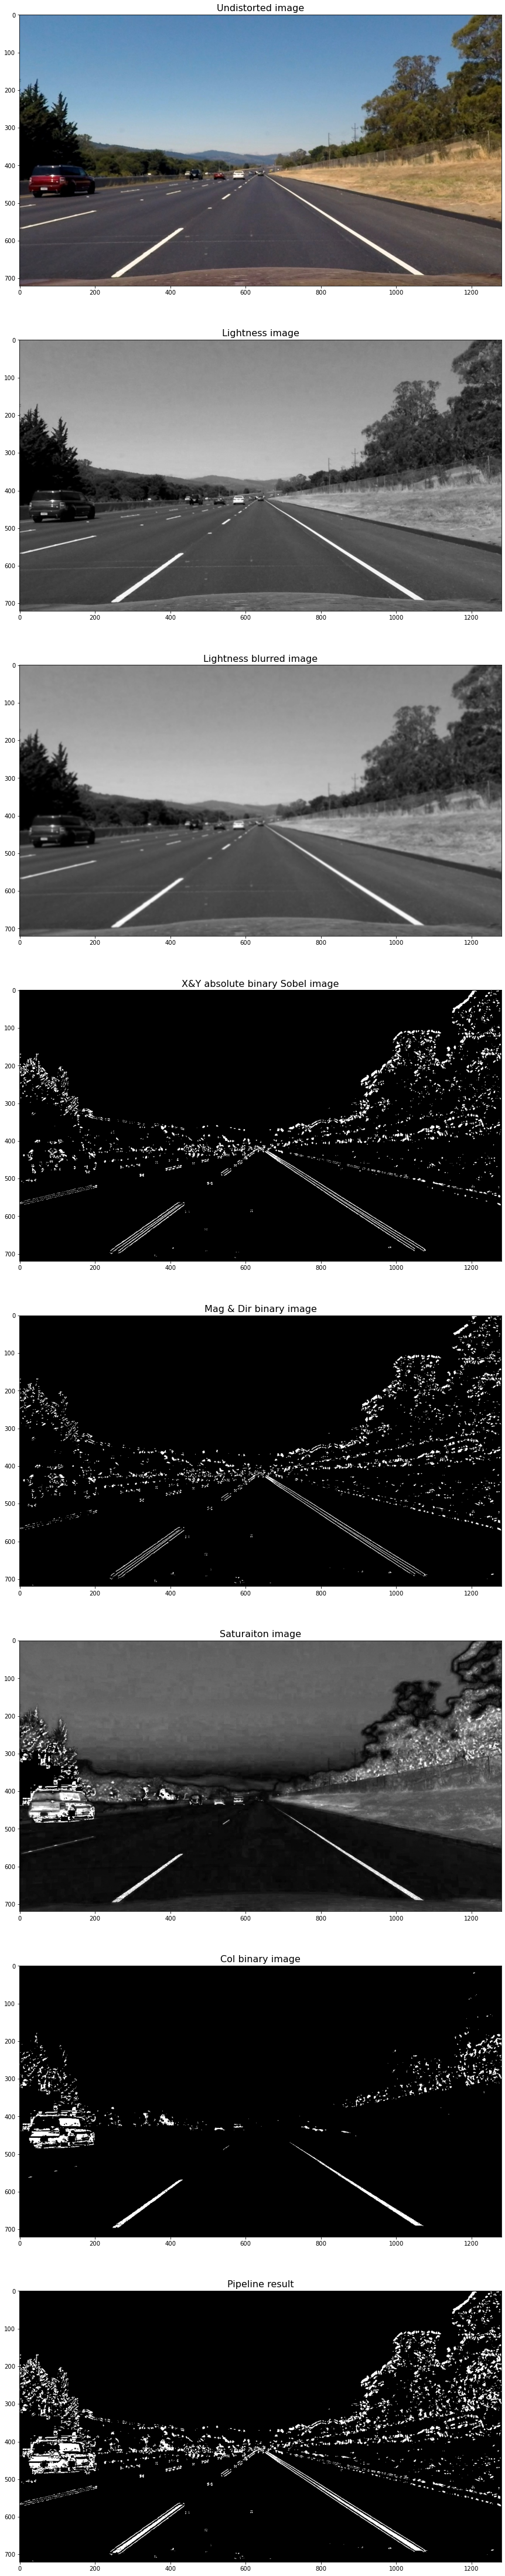

In [8]:
# Pipeline parameters
ksize=7
abs_thresh=(20, 100)
mag_thresh=(30, 100)
dir_thresh=(0.7, 1.3)
col_thresh=(170, 255)
# Pipeline
img_filtered = filter_pipeline(img_undistort, ksize, abs_thresh, mag_thresh, dir_thresh, col_thresh)

# Plot the intermediate and final result
f, ((ax1), (ax2), (ax3), (ax4), (ax5), (ax6), (ax7), (ax8)) = plt.subplots(8, 1, figsize=(20, 80))

ax1.imshow(cv2.cvtColor(img_undistort, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted image', fontsize=16)

# HLS conversion
img_hls = cv2.cvtColor(img_undistort, cv2.COLOR_BGR2HLS)
img_hls_l = img_hls[:,:,1]
ax2.imshow(img_hls_l, cmap='gray')
ax2.set_title('Lightness image', fontsize=16)

img_hls_l = gaussian_blur(img_hls_l, ksize)
ax3.imshow(img_hls_l, cmap='gray')
ax3.set_title('Lightness blurred image', fontsize=16)

gradx_binary = abs_sobel_thresh(img_hls_l, 'x', ksize, abs_thresh)
grady_binary = abs_sobel_thresh(img_hls_l, 'y', ksize, abs_thresh)
gradxy_binary = np.zeros_like(img_hls_l)
gradxy_binary[(gradx_binary == 1) & (grady_binary == 1)] = 1
ax4.imshow(gradxy_binary, cmap='gray')
ax4.set_title('X&Y absolute binary Sobel image', fontsize=16)

mag_binary = mag_threshold(img_hls_l, ksize, mag_thresh)
dir_binary = dir_threshold(img_hls_l, ksize, dir_thresh)
magdir_binary = np.zeros_like(img_hls_l)
magdir_binary[(mag_binary == 1) & (dir_binary == 1)] = 1
ax5.imshow(magdir_binary, cmap='gray')
ax5.set_title('Mag & Dir binary image', fontsize=16)

img_hls_s = img_hls[:,:,2]
ax6.imshow(img_hls_s, cmap='gray')
ax6.set_title('Saturaiton image', fontsize=16)

col_binary = col_threshold(img_hls_s, ksize, col_thresh)
ax7.imshow(col_binary, cmap='gray')
ax7.set_title('Col binary image', fontsize=16)

ax8.imshow(img_filtered, cmap='gray')
ax8.set_title('Pipeline result', fontsize=16)
plt.show()

## Perspective transform
Apply a perspective transform to rectify binary image ("birds-eye view").

In [59]:
def determine_region_of_interest(img, apex_width_pct=0.2, apex_height_pct=0.4, bottom_width_pct=1.0):
    # Define a four sided polygon to mask
    # Top left, top right, bottom right, bottom left
    
    # Quadrilatere top size
    apex_width = img.shape[1]*apex_width_pct
    apex_height = img.shape[0]*apex_height_pct
    bottom_width = img.shape[1]*bottom_width_pct
    
    # Quadrilatere points
    left_bottom = [(img.shape[1]-bottom_width)/2, img.shape[0]]
    right_bottom = [(img.shape[1]+bottom_width)/2, img.shape[0]]
    left_top = [(img.shape[1]-apex_width)/2, (img.shape[0]-apex_height)]
    right_top = [(img.shape[1]+apex_width)/2, (img.shape[0]-apex_height)]
    
    vertices=np.array([
            [left_top[0],left_top[1]], 
            [right_top[0],right_top[1]],
            [right_bottom[0],right_bottom[1]],
            [left_bottom[0],left_bottom[1]]
        ],
        dtype=np.int32)
    
    return vertices

def region_of_interest_mask(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # Defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color
    # Don't forget warp vertices in an array
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def determine_dst_region_of_interest(vertices):
    # Define a four sided destination rectangle    
    # Top left, top right, bottom right, bottom left
    dst_vertices=np.array([
            [vertices[3][0], 0], 
            [vertices[2][0], 0],
            [vertices[2][0], vertices[2][1]],
            [vertices[3][0], vertices[3][1]]
        ],
        dtype=np.int32)
    
    return dst_vertices

def birds_eye_view_warp(img_masked, vertices, dst_vertices):    
    src = vertices.astype('float32')
    dst = dst_vertices.astype('float32')
      
    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    M_inv = cv2.getPerspectiveTransform(src, dst) # Inverse transformation
    
    warped_img = cv2.warpPerspective(img_masked, M, (img_masked.shape[1], img_masked.shape[0]), flags=cv2.INTER_LINEAR) # Image warping
    
    return warped_img



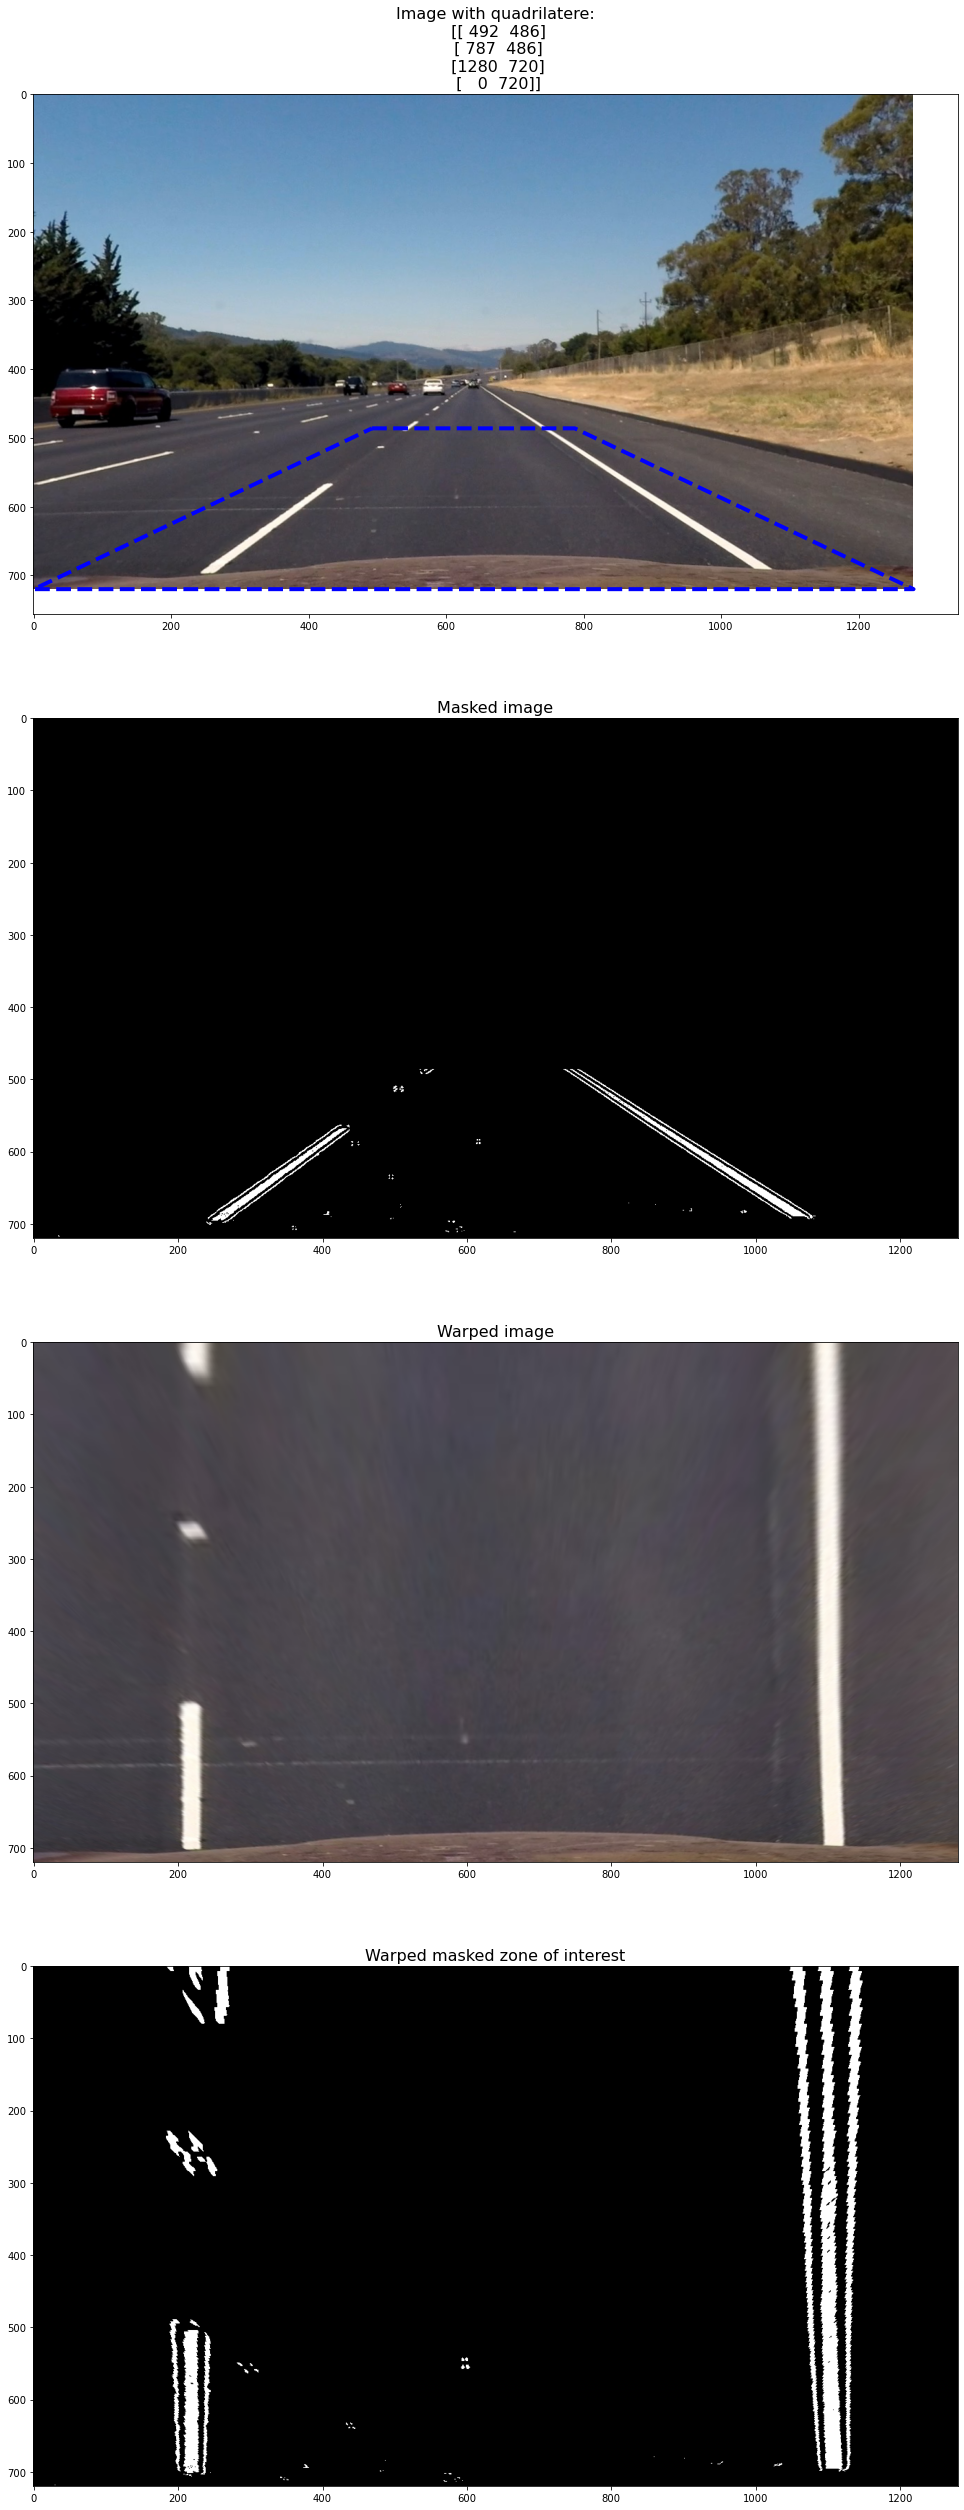

In [60]:
apex_width_pct=0.23
apex_height_pct=0.325
bottom_width_pct=1

vertices = determine_region_of_interest(img_filtered, apex_width_pct, apex_height_pct, bottom_width_pct)
dst_vertices = determine_dst_region_of_interest(vertices)    
img_masked = region_of_interest_mask(img_filtered, vertices)
img_undist_warped = birds_eye_view_warp(img_undistort, vertices, dst_vertices)
img_mask_warped = birds_eye_view_warp(img_masked, vertices, dst_vertices)

# Plot the result
f, ((ax1), (ax2), (ax3), (ax4)) = plt.subplots(4, 1, figsize=(20, 44))

ax1.imshow(cv2.cvtColor(img_undistort, cv2.COLOR_BGR2RGB))
ax1.set_title('Image with quadrilatere:\n {}'.format(vertices), fontsize=16)
x = [vertices[0][0], vertices[1][0], vertices[2][0], vertices[3][0], vertices[0][0]]
y = [vertices[0][1], vertices[1][1], vertices[2][1], vertices[3][1], vertices[0][1]]
ax1.plot(x, y, 'b--', lw=4)

ax2.imshow(img_masked, cmap='gray')
ax2.set_title('Masked image', fontsize=16)

ax3.imshow(cv2.cvtColor(img_undist_warped, cv2.COLOR_BGR2RGB))
ax3.set_title('Warped image', fontsize=16)

ax4.imshow(img_mask_warped, cmap='gray')
ax4.set_title('Warped masked zone of interest', fontsize=16)
plt.show()

## Lane detection and boundaries
Detect lane pixels and fit to find the lane boundary.

In [61]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin # Update this
        win_xleft_high = leftx_current + margin # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin # Update this

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (0, 255, 0), 2)

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

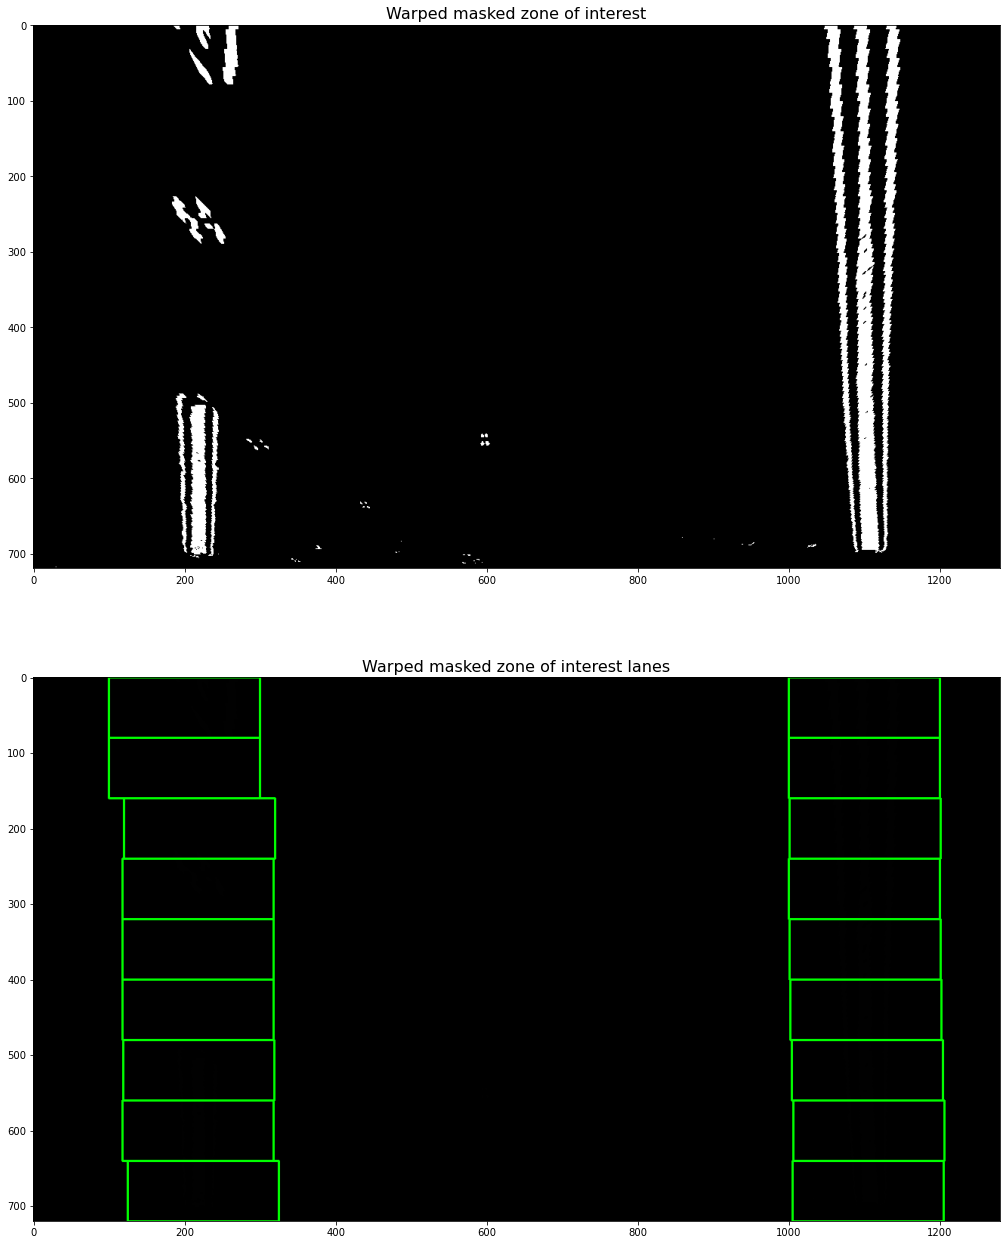

In [62]:
nwindows=9
margin=100
minpix=50
leftx, lefty, rightx, righty, img_mask_warped_rect = find_lane_pixels(img_mask_warped, nwindows, margin, minpix)

# Plot the result
f, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(20, 22))

ax1.imshow(img_mask_warped, cmap='gray')
ax1.set_title('Warped masked zone of interest', fontsize=16)

ax2.imshow(img_mask_warped_rect)
ax2.set_title('Warped masked zone of interest lanes', fontsize=16)

plt.show()

## Lane curvature determination
Determine the curvature of the lane and vehicle position with respect to center.

In [63]:
def fit_polynomial(binary_warped, nwindows=9, margin=100, minpix=50):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, nwindows, margin, minpix)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty
        
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    out_img[ploty.astype('int32'), left_fitx.astype('int32')] = [255, 255, 0]
    out_img[ploty.astype('int32'), right_fitx.astype('int32')] = [255, 255, 0]

    return left_fit, right_fit, ploty, left_fitx, right_fitx, out_img

def measure_curvature_real(binary_warped, left_fitx, right_fitx, ym_per_pix):
    # Find our lane pixels first
    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = meters per pixel in y dimension
    #xm_per_pix = meters per pixel in x dimension
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    
    ## Implement the calculation of the left line here
    left_curverad = ((1 + (2 * left_fitx[0] * y_eval * ym_per_pix + left_fitx[1]) ** 2) ** (3 / 2)) / np.abs(2 * left_fitx[0])
    ## Implement the calculation of the right line here
    right_curverad = ((1 + (2 * right_fitx[0] * y_eval * ym_per_pix + right_fitx[1]) ** 2) ** (3 / 2)) / np.abs(2 * right_fitx[0])
    
    return left_curverad, right_curverad

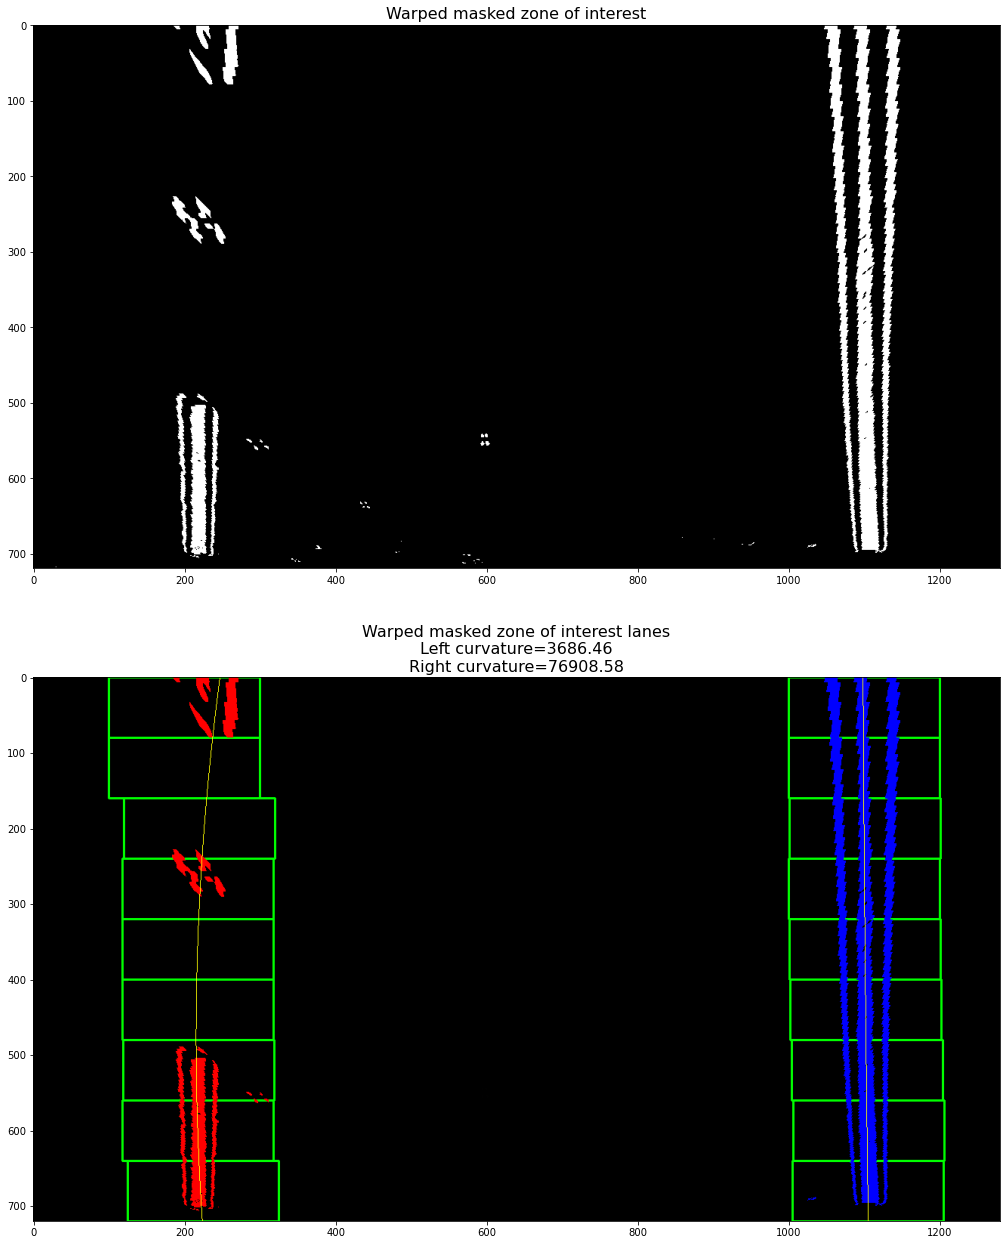

In [64]:
left_fit, right_fit, ploty, left_fitx, right_fitx, img_mask_warped_lanes = fit_polynomial(img_mask_warped, nwindows, margin, minpix)
# Almost same height as course, reusing parameters
ym_per_pix=30/720

left_curverad, right_curverad = measure_curvature_real(img_mask_warped, left_fit, right_fit, ym_per_pix)
# Plot the result
f, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(20, 22))

ax1.imshow(img_mask_warped, cmap='gray')
ax1.set_title('Warped masked zone of interest', fontsize=16)

ax2.imshow(img_mask_warped_lanes)
ax2.set_title('Warped masked zone of interest lanes\nLeft curvature={:6.2f}\nRight curvature={:6.2f}'.format(left_curverad, right_curverad), fontsize=16)

plt.show()

## Vehicle position detection
Detect the vehicle position against the center in meters

In [65]:
def determine_vehicle_position(binary_warped, left_fit, right_fit, xm_per_pix):    
    
    # Define y-value where we want to compute distance
    y_eval = binary_warped.shape[0]-1
    
    ## Implement the calculation of the left line here
    left_lane_pos = (left_fit[0] * (y_eval**2) + left_fit[1] * y_eval + left_fit[2])
    ## Implement the calculation of the right line here
    right_lane_pos = (right_fit[0] * (y_eval**2) + right_fit[1] * y_eval + right_fit[2])
    
    lane_center_pos = left_lane_pos + ((right_lane_pos - left_lane_pos) / 2)
    
    # Left from center is negative values / Right from center is positive values
    vehicle_position = lane_center_pos - (binary_warped.shape[1] / 2)
    vehicle_position_meter = vehicle_position * xm_per_pix
   
    return vehicle_position_meter, lane_center_pos, vehicle_position

In [66]:
xm_per_pix=3.7/700
vehicle_position_meter, lane_center_pos, vehicle_position = determine_vehicle_position(img_mask_warped, left_fit, right_fit, xm_per_pix)

print('Vehicle is {:2.2f} metters away from lane center'.format(vehicle_position_meter))

Vehicle is 0.13 metters away from lane center


## Original image and lane superposition
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [142]:
def unwarp_lanes(img, ploty, left_fitx, right_fitx, vertices, dst_vertices, color=(0,0,255), thickness=15):
    
    lanes_binary = np.zeros_like(img)
    
    # Colors in the left and right lane regions
    left_points = [[b,a] for a, b in zip(ploty.astype('int32'), left_fitx.astype('int32'))]    
    left_points=np.array([left_points], dtype=np.int32)
    cv2.polylines(lanes_binary, left_points, False, color, thickness)
    right_points = [[b,a] for a, b in zip(ploty.astype('int32'), right_fitx.astype('int32'))]    
    right_points=np.array([right_points], dtype=np.int32)
    cv2.polylines(lanes_binary, right_points, False, color, thickness)
    #lanes_binary[ploty.astype('int32'), left_fitx.astype('int32')] = [255, 0, 0]
    #lanes_binary[ploty.astype('int32'), right_fitx.astype('int32')] = [255, 0, 0]
    #
    #lanes_binary[ploty.astype('int32'), left_fitx.astype('int32')-1] = [255, 0, 0]
    #lanes_binary[ploty.astype('int32'), right_fitx.astype('int32')-1] = [255, 0, 0]
    #
    #lanes_binary[ploty.astype('int32'), left_fitx.astype('int32')+1] = [255, 0, 0]
    #lanes_binary[ploty.astype('int32'), right_fitx.astype('int32')+1] = [255, 0, 0]
    
    src = vertices.astype('float32')
    dst = dst_vertices.astype('float32')
    
    M_inv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation
    
    warped_img = cv2.warpPerspective(lanes_binary, M_inv, (lanes_binary.shape[1], lanes_binary.shape[0]), flags=cv2.INTER_LINEAR) # Image warping
    
    return warped_img, lanes_binary


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the mask    
    `initial_img` is the real image
    
    The result image is computed as follows:    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

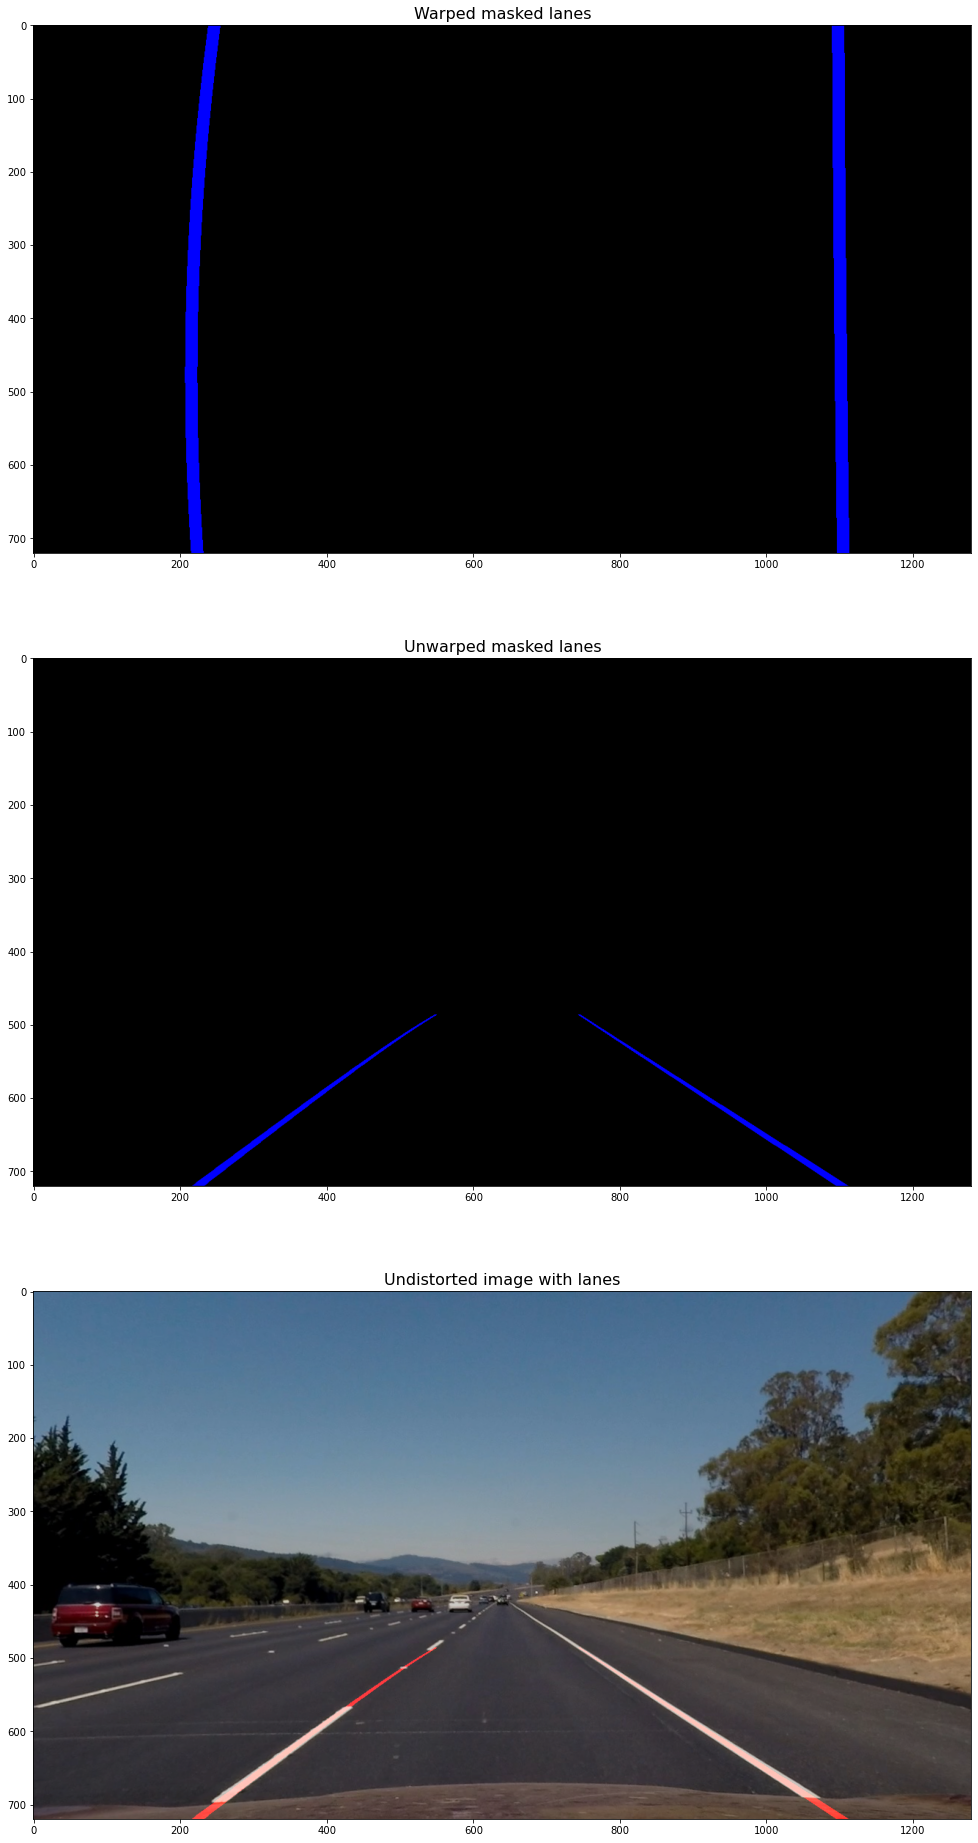

In [143]:
img_unwarped_lanes_mask, img_lanes_mask = unwarp_lanes(img_undistort, ploty, left_fitx, right_fitx, vertices, dst_vertices)
img_weighted = weighted_img(img_unwarped_lanes_mask, img_undistort, α=0.8, β=1., γ=0.)

# Plot the result
f, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(20, 33))

ax1.imshow(img_lanes_mask, cmap='gray')
ax1.set_title('Warped masked lanes', fontsize=16)

ax2.imshow(img_unwarped_lanes_mask, cmap='gray')
ax2.set_title('Unwarped masked lanes', fontsize=16)

ax3.imshow(cv2.cvtColor(img_weighted, cv2.COLOR_BGR2RGB), cmap='gray')
ax3.set_title('Undistorted image with lanes', fontsize=16)

plt.show()

## Full pipeline

In [151]:
def process_image(image):
    img_processed = np.zeros_like(image)
    return img_processed

## Video processing

In [152]:
clip_path = VIDEO_PATH_CHALLENGE
clip_processed_path = '{}processed.mp4'.format(clip_path.replace(".mp4", "_"))
#video = HARDER_VIDEO_PATH_CHALLENGE
clip = VideoFileClip(clip_path).subclip(0,5)
clip_processed = clip.fl_image(process_image)
%time clip_processed.write_videofile(clip_processed_path, audio=False)

t:   1%|▏         | 2/150 [00:00<00:07, 20.00it/s, now=None]

Moviepy - Building video challenge_video_processed.mp4.
Moviepy - Writing video challenge_video_processed.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_processed.mp4
Wall time: 2.07 s


In [154]:
HTML("""
<video width="850" height="480" controls>
  <source src="{0}">
</video>
""".format(clip_processed_path))